In [115]:
import sys 
# !{sys.executable} -m pip uninstall https://github.com/JonathanRaiman/glove/archive/master.zip

In [31]:
# !{sys.executable} -m pip install plotly

  Using cached https://files.pythonhosted.org/packages/e3/67/eb2b2be7a63a66548abea92447fc04d9abf363520f1af6145c5f033cd1b3/plotly-4.3.0-py2.py3-none-any.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Library/Frameworks/Python.framework/Versions/3.6/etc/jupyter/nbconfig'
Consider using the `--user` option or check the permissions.

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# ! export CC="/usr/local/bin/gcc-6"
# ! export CFLAGS="-Wa,-q"
# ! pip install glove_python

Processing /Users/anastasia/Library/Caches/pip/wheels/1d/17/11/0042cd301e3fb964a60feb46378e6ac633d6d4fa7cc707da79/glove-1.0.0-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/49/dd/f2fe213a181eaba2a33b9430c03fc9ef2a7c7f1a5fdd426dacbb45f6a1e0/Cython-0.29.14-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl


In [1]:
import re
import os
import operator
import numpy as np
import pandas as pd
import nltk
import string
import collections
from sklearn.manifold import TSNE
from sklearn import preprocessing

from os.path import join, exists
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import glove
from glove.corpus import Corpus
from glove.glove import Glove

# from glove import Glove

from keras.utils.data_utils import get_file
from keras.utils import to_categorical, np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Masking, SimpleRNN, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras import regularizers

import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


# Loading

# Friends and The Office

In [2]:
friends_df = pd.read_csv("./data/friends.csv")
del friends_df['Unnamed: 0']
office_df = pd.read_csv("./data/the_office.csv")

In [3]:
chandler_df = friends_df.loc[friends_df["Speaker"] == "Chandler"]
chandler_df = chandler_df.dropna()

In [4]:
chandler_df

Location  \
2                                       Mike's apartment   
8                        Monica and Chandler's apartment   
24                                          Central Perk   
26                                   Chandler and Joey's   
34                                     Monica’s birthday   
...                                                  ...   
93324                                Chandler and Joey's   
93325                                Chandler and Joey's   
93327                                Monica and Rachel's   
93330   Camera fades to one of the band members playi...   
93331                    Monica and Chandler's apartment   

                                                   Scene  Season   Speaker  \
2                        His phone rings and he picks up       9  Chandler   
8            Chandler is there, Phoebe and Rachel enter,       9  Chandler   
24      Chandler and Joey are there, Joey is looking ...       5  Chandler   
26                    Joey is coming in from the bedroom       3  Chandler   
34                         it’s just after the surprise,       7  Chandler   
...                                                  ...     ...       ...   
93324   erm, Monica and Rachel's, Chandler is there a...       4  Chandler   
93325   Joey is watching Quincy M,E, as Chandler is w...       3  Chandler   
93327   the next morning, Chandler, Joey, and Phoebe ...       5  Chandler   
93330   The chapel is full of guest, A groomsmen esco...       4  Chandler   
93331      Chandler is watching TV and Monica is cooking      10  Chandler   

                                                    Text  
2      Phoebe is going to say "yes"? That's, that's g...  
8                                 What? That's terrible!  
24                                         That's a pig.  
26                                  Nope, not this time.  
34      She doesn’t want her parents to know she’s dr...  
...                                                  ...  
93324  What do you want from me, I’ve never met the g...  
93325                Oh my God! Who’s gonna watch that?!  
93327                                           Condoms?  
93330                     What we did last night was....  
93331  I'm telling ya! It's gonna happen. Next year i...  

[14170 rows x 5 columns]

In [5]:
chandler_lines = np.array(friends_df.loc[friends_df["Speaker"] == "Chandler"]["Text"])
michael_lines = np.array(office_df.loc[office_df["speaker"] == "Michael"]["line_text"])

In [6]:
michael_df = office_df.loc[office_df["speaker"] == "Michael"]

In [7]:
michael_df

id  season  episode  scene  \
0          1       1        1      1   
2          3       1        1      1   
4          5       1        1      1   
5          6       1        1      2   
6          7       1        1      3   
...      ...     ...      ...    ...   
44693  44694       7       21     49   
44694  44695       7       21     50   
44695  44696       7       21     51   
59750  59751       9       23     68   
59797  59798       9       23     84   

                                               line_text  speaker  deleted  
0      All right Jim. Your quarterlies look very good...  Michael    False  
2      So you've come to the master for guidance? Is ...  Michael    False  
4        All right. Well, let me show you how it's done.  Michael    False  
5      [on the phone] Yes, I'd like to speak to your ...  Michael    False  
6      I've, uh, I've been at Dunder Mifflin for 12 y...  Michael    False  
...                                                  ...      ...      ...  
44693                    Later guys. [leaves the office]  Michael    False  
44694  Got almost everybody. So... Holly's my family ...  Michael    False  
44695  [putting his shoes back on, talking to the cam...  Michael    False  
59750                            That���s what she said.  Michael    False  
59797  [crying] I feel like all my kids grew up and t...  Michael    False  

[12137 rows x 7 columns]

In [84]:
phoebe_df = friends_df.loc[friends_df["Speaker"] == "Phoebe"]
phoebe_df = chandler_df.dropna()
phoebe_lines = np.array(friends_df.loc[friends_df["Speaker"] == "Phoebe"]["Text"])

# Jokes

In [8]:
reddit_df = pd.read_json('./data/reddit_jokes.json').dropna()[['title', 'body', 'score']]
stupid_df = pd.read_json('./data/stupidstuff.json').dropna()[['body', 'rating']]

In [9]:
reddit_df["body"] = reddit_df["title"].map(str) + " " + reddit_df["body"]
del reddit_df['title']

### Mapping and normalising all scores to be from 0 to 5

In [10]:
reddit_df['score'].max()/6

8087.666666666667

In [11]:
reddit_df.loc[(reddit_df.score <= 8087), 'score'] = 0
reddit_df.loc[(reddit_df.score > 8087) & (reddit_df.score < 8087*2), 'score'] = 1
reddit_df.loc[(reddit_df.score > 8087*2) & (reddit_df.score < 8087*3), 'score'] = 2
reddit_df.loc[(reddit_df.score > 8087*3) & (reddit_df.score < 8087*4), 'score'] = 3
reddit_df.loc[(reddit_df.score > 8087*4) & (reddit_df.score < 8087*5), 'score'] = 4
reddit_df.loc[(reddit_df.score > 8087*5), 'score'] = 5

In [12]:
stupid_df.loc[(stupid_df.rating < 0.5), 'rating'] = 0
stupid_df.loc[(stupid_df.rating >= 0.5) & (stupid_df.rating < 1.5), 'rating'] = 1
stupid_df.loc[(stupid_df.rating >= 1.5) & (stupid_df.rating < 2.5), 'rating'] = 2
stupid_df.loc[(stupid_df.rating >= 2.5) & (stupid_df.rating < 3.5), 'rating'] = 3
stupid_df.loc[(stupid_df.rating >= 3.5) & (stupid_df.rating < 4.5), 'rating'] = 4
stupid_df.loc[(stupid_df.rating >= 4.5), 'rating'] = 5

In [13]:
stupid_df['rating'] = stupid_df['rating'].astype(int)

In [14]:
reddit_df.rename(columns={'body': 'joke', 'score': 'rating'}, inplace=True)
stupid_df.rename(columns={'body': 'joke', 'rating': 'rating'}, inplace=True)

In [15]:
all_jokes_df = pd.concat([reddit_df, stupid_df])
all_jokes_df = all_jokes_df.sample(frac=1).reset_index(drop=True)

In [16]:
all_jokes_df

joke  rating
0       That deli has a reputation for sub-par hoagies...       0
1       A neutron orders a drink at a bar A neutron or...       0
2       The American education system. That's it. That...       0
3       I got peanut butter on my camera Now every pic...       0
4                             I'm Going To Hell For This        0
...                                                   ...     ...
198321                             Fifa ethics committee        0
198322  Complained to my wife about our sex life dimin...       0
198323      Where do magical animals go to jail? Azkabarn       0
198324          Never trust Atoms They make up everything       0
198325  Even if you get gold at the special olympics Y...       0

[198326 rows x 2 columns]

# Hate Speech

In [17]:
hate_speech_df = pd.read_csv("./data/hate_speech.csv")
del hate_speech_df['Unnamed: 0']
hate_speech_df = hate_speech_df[['tweet', 'class']]

In [18]:
hate_speech_df

tweet  class
0      !!! RT @mayasolovely: As a woman you shouldn't...      2
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1
...                                                  ...    ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      1
24779  you've gone and broke the wrong heart baby, an...      2
24780  young buck wanna eat!!.. dat nigguh like I ain...      1
24781              youu got wild bitches tellin you lies      1
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      2

[24783 rows x 2 columns]

# Cleaning

In [19]:
def clean_text(text):  
    text = text.rstrip().lstrip()
    text = text.translate(string.punctuation)

    ## Convert words to lower case and split them
    text = text.lower().split()
    if "&amp;" in text:
        text.remove("&amp;")
    for el in text:
        if "@" in el:
            text.remove(el)

    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]

    text = " ".join(text)
    text = text.replace('!', '')
    text = text.replace("+", "")
    text = text.replace(";", "")
    # Clean the text
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace('amp;', '')

    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [20]:
all_jokes_df['joke'] = all_jokes_df['joke'].map(lambda x: clean_text(x))

In [21]:
hate_speech_df['tweet'] = hate_speech_df['tweet'].map(lambda x: clean_text(x))

In [22]:
all_jokes_df

joke  rating
0         deli reput sub - par hoagi but one exact averag       0
1       neutron order drink bar neutron order drink ba...       0
2                  american educ system that it that joke       0
3               got peanut butter camera everi pictur jif       0
4                                            i am go hell       0
...                                                   ...     ...
198321                                fifa ethic committe       0
198322    complain wife sex life diminish zero fuck given       0
198323                           magic anim jail azkabarn       0
198324                      never trust atom make everyth       0
198325  even get gold special olymp your still retard ...       0

[198326 rows x 2 columns]

In [23]:
hate_speech_df

tweet  class
0      woman complain clean hous man alway take trash...      2
1      boy dat cold tyga dwn bad cuffin dat hoe st place      1
2             dawg ever fuck bitch start cri confus shit      1
3                             viva base look like tranni      1
4            shit hear might true might faker bitch told      1
...                                                  ...    ...
24778  you muthaf in lie pearl right trash now mine b...      1
24779    gone broke wrong heart babi drove redneck crazi      2
24780  young buck wanna eat dat nigguh like aint fuck...      1
24781                     youu got wild bitch tellin lie      1
24782  ruffl ntac eileen dahlia beauti color combin p...      2

[24783 rows x 2 columns]

In [24]:
labels_jokes = all_jokes_df['rating'].map(lambda x : 1 if int(x) >= 3 else 0) #funny=1, not funny=0
labels_hate = hate_speech_df['class'].map(lambda x : 1 if int(x) <= 1 else 0) #hate=1, not hate=0

In [25]:
all_jokes_df['rating'] = all_jokes_df['rating'].map(lambda x : 1 if int(x) >= 3 else 0)
hate_speech_df['class'] = hate_speech_df['class'].map(lambda x : 1 if int(x) <= 1 else 0)

0 - hate speech 1 - offensive language 2 - neither

# include non-offensive tweets in the everything dataset

In [26]:
jokes_new = all_jokes_df
hate_new = hate_speech_df
jokes_new.rename(columns={'joke': 'text', 'rating': 'category'}, inplace=True)
hate_new.rename(columns={'tweet': 'text', 'class': 'category'}, inplace=True)
jokes_new['category'] = 1
hate_new.loc[(hate_new.category == 0), 'category'] = 0 # neutral data
hate_new.loc[(hate_new.category == 1), 'category'] = 2 # hateful data

everything_df = pd.concat([jokes_new, hate_new])
everything_df = everything_df.sample(frac=1).reset_index(drop=True)
labels_everything = everything_df['category']

0 = neutral, 1 = funny, 2 = offensive

In [27]:
everything_df

text  category
0        rent boy i would charg minut could not last hour         1
1       play ball young man went studi abroad one day ...         1
2       unbeliev american refus kill oki mean american...         2
3       two number part fraction one top say i am go r...         1
4         call black guy reneg promis unreli racist prick         1
...                                                   ...       ...
223104        make paper ball trash http : t co moxmrsoov         0
223105  what is differ jew boy scout boy scout come ho...         1
223106  street pari well - known transvestit communiti...         1
223107  former polic offic offer servic appear court y...         1
223108  woman met children name david ask call one the...         1

[223109 rows x 2 columns]

# Balancing it out

In [28]:
everything_df['category'].value_counts()

1    198326
2     20620
0      4163
Name: category, dtype: int64

In [78]:
df_binary = everything_df[everything_df['category'] != 0]
df_binary = (df_binary.groupby('category', as_index=False)
        .apply(lambda x: x.sample(n=20620))
        .reset_index(drop=True))
df_binary = df_binary.sample(frac=1).reset_index(drop=True)
df_binary.loc[(df_binary.category == 1), 'category'] = 0 # funny data
df_binary.loc[(df_binary.category == 2), 'category'] = 1 # hateful data
labels_binary = df_binary['category']

In [79]:
df_binary['category'].value_counts()

1    20620
0    20620
Name: category, dtype: int64

In [29]:
df_final_everything = (everything_df.groupby('category', as_index=False)
        .apply(lambda x: x.sample(n=4163))
        .reset_index(drop=True))
df_final_everything = df_final_everything.sample(frac=1).reset_index(drop=True)

In [31]:
labels_final = df_final_everything['category']

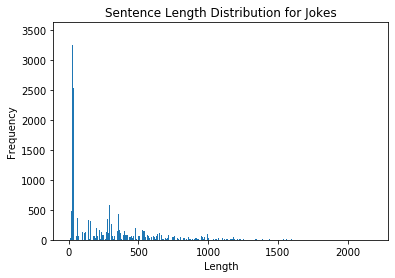

In [32]:
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in all_jokes_df['text']:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution for Jokes")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

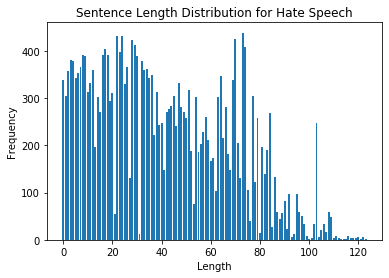

In [33]:
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in hate_speech_df['text']:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution for Hate Speech")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

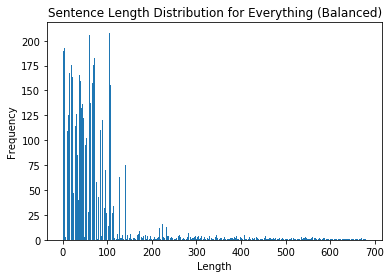

In [36]:
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in df_final_everything['text']:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution for Everything (Balanced)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [37]:
vocabulary_size = 400000 #20000
tokenizer_jokes = Tokenizer(num_words= vocabulary_size)
tokenizer_jokes.fit_on_texts(all_jokes_df['text'])

sequences_jokes = tokenizer_jokes.texts_to_sequences(all_jokes_df['text'])
data_jokes = pad_sequences(sequences_jokes, maxlen=300)

In [38]:
tokenizer_hate = Tokenizer(num_words= vocabulary_size)
tokenizer_hate.fit_on_texts(hate_speech_df['text'])

sequences_hate = tokenizer_hate.texts_to_sequences(hate_speech_df['text'])
data_hate = pad_sequences(sequences_hate, maxlen=100)

In [39]:
print(data_jokes.shape)
print(data_hate.shape)

(198326, 300)
(24783, 100)


In [40]:
tokenizer_final = Tokenizer(num_words= vocabulary_size)
tokenizer_final.fit_on_texts(df_final_everything['text'])

sequences_final = tokenizer_final.texts_to_sequences(df_final_everything['text'])
data_final = pad_sequences(sequences_final, maxlen=200)

In [80]:
tokenizer_binary = Tokenizer(num_words= vocabulary_size)
tokenizer_binary.fit_on_texts(df_binary['text'])

sequences_binary = tokenizer_binary.texts_to_sequences(df_binary['text'])
data_binary = pad_sequences(sequences_binary, maxlen=200)

# GloVe

In [41]:
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [42]:
embedding_matrix_jokes = np.zeros((vocabulary_size, 100))
for word, index in tokenizer_jokes.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_jokes[index] = embedding_vector

In [43]:
embedding_matrix_hate = np.zeros((vocabulary_size, 100))
for word, index in tokenizer_hate.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_hate[index] = embedding_vector

In [44]:
embedding_matrix_final = np.zeros((vocabulary_size, 100))
for word, index in tokenizer_final.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_final[index] = embedding_vector

In [81]:
embedding_matrix_binary = np.zeros((vocabulary_size, 100))
for word, index in tokenizer_binary.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_binary[index] = embedding_vector

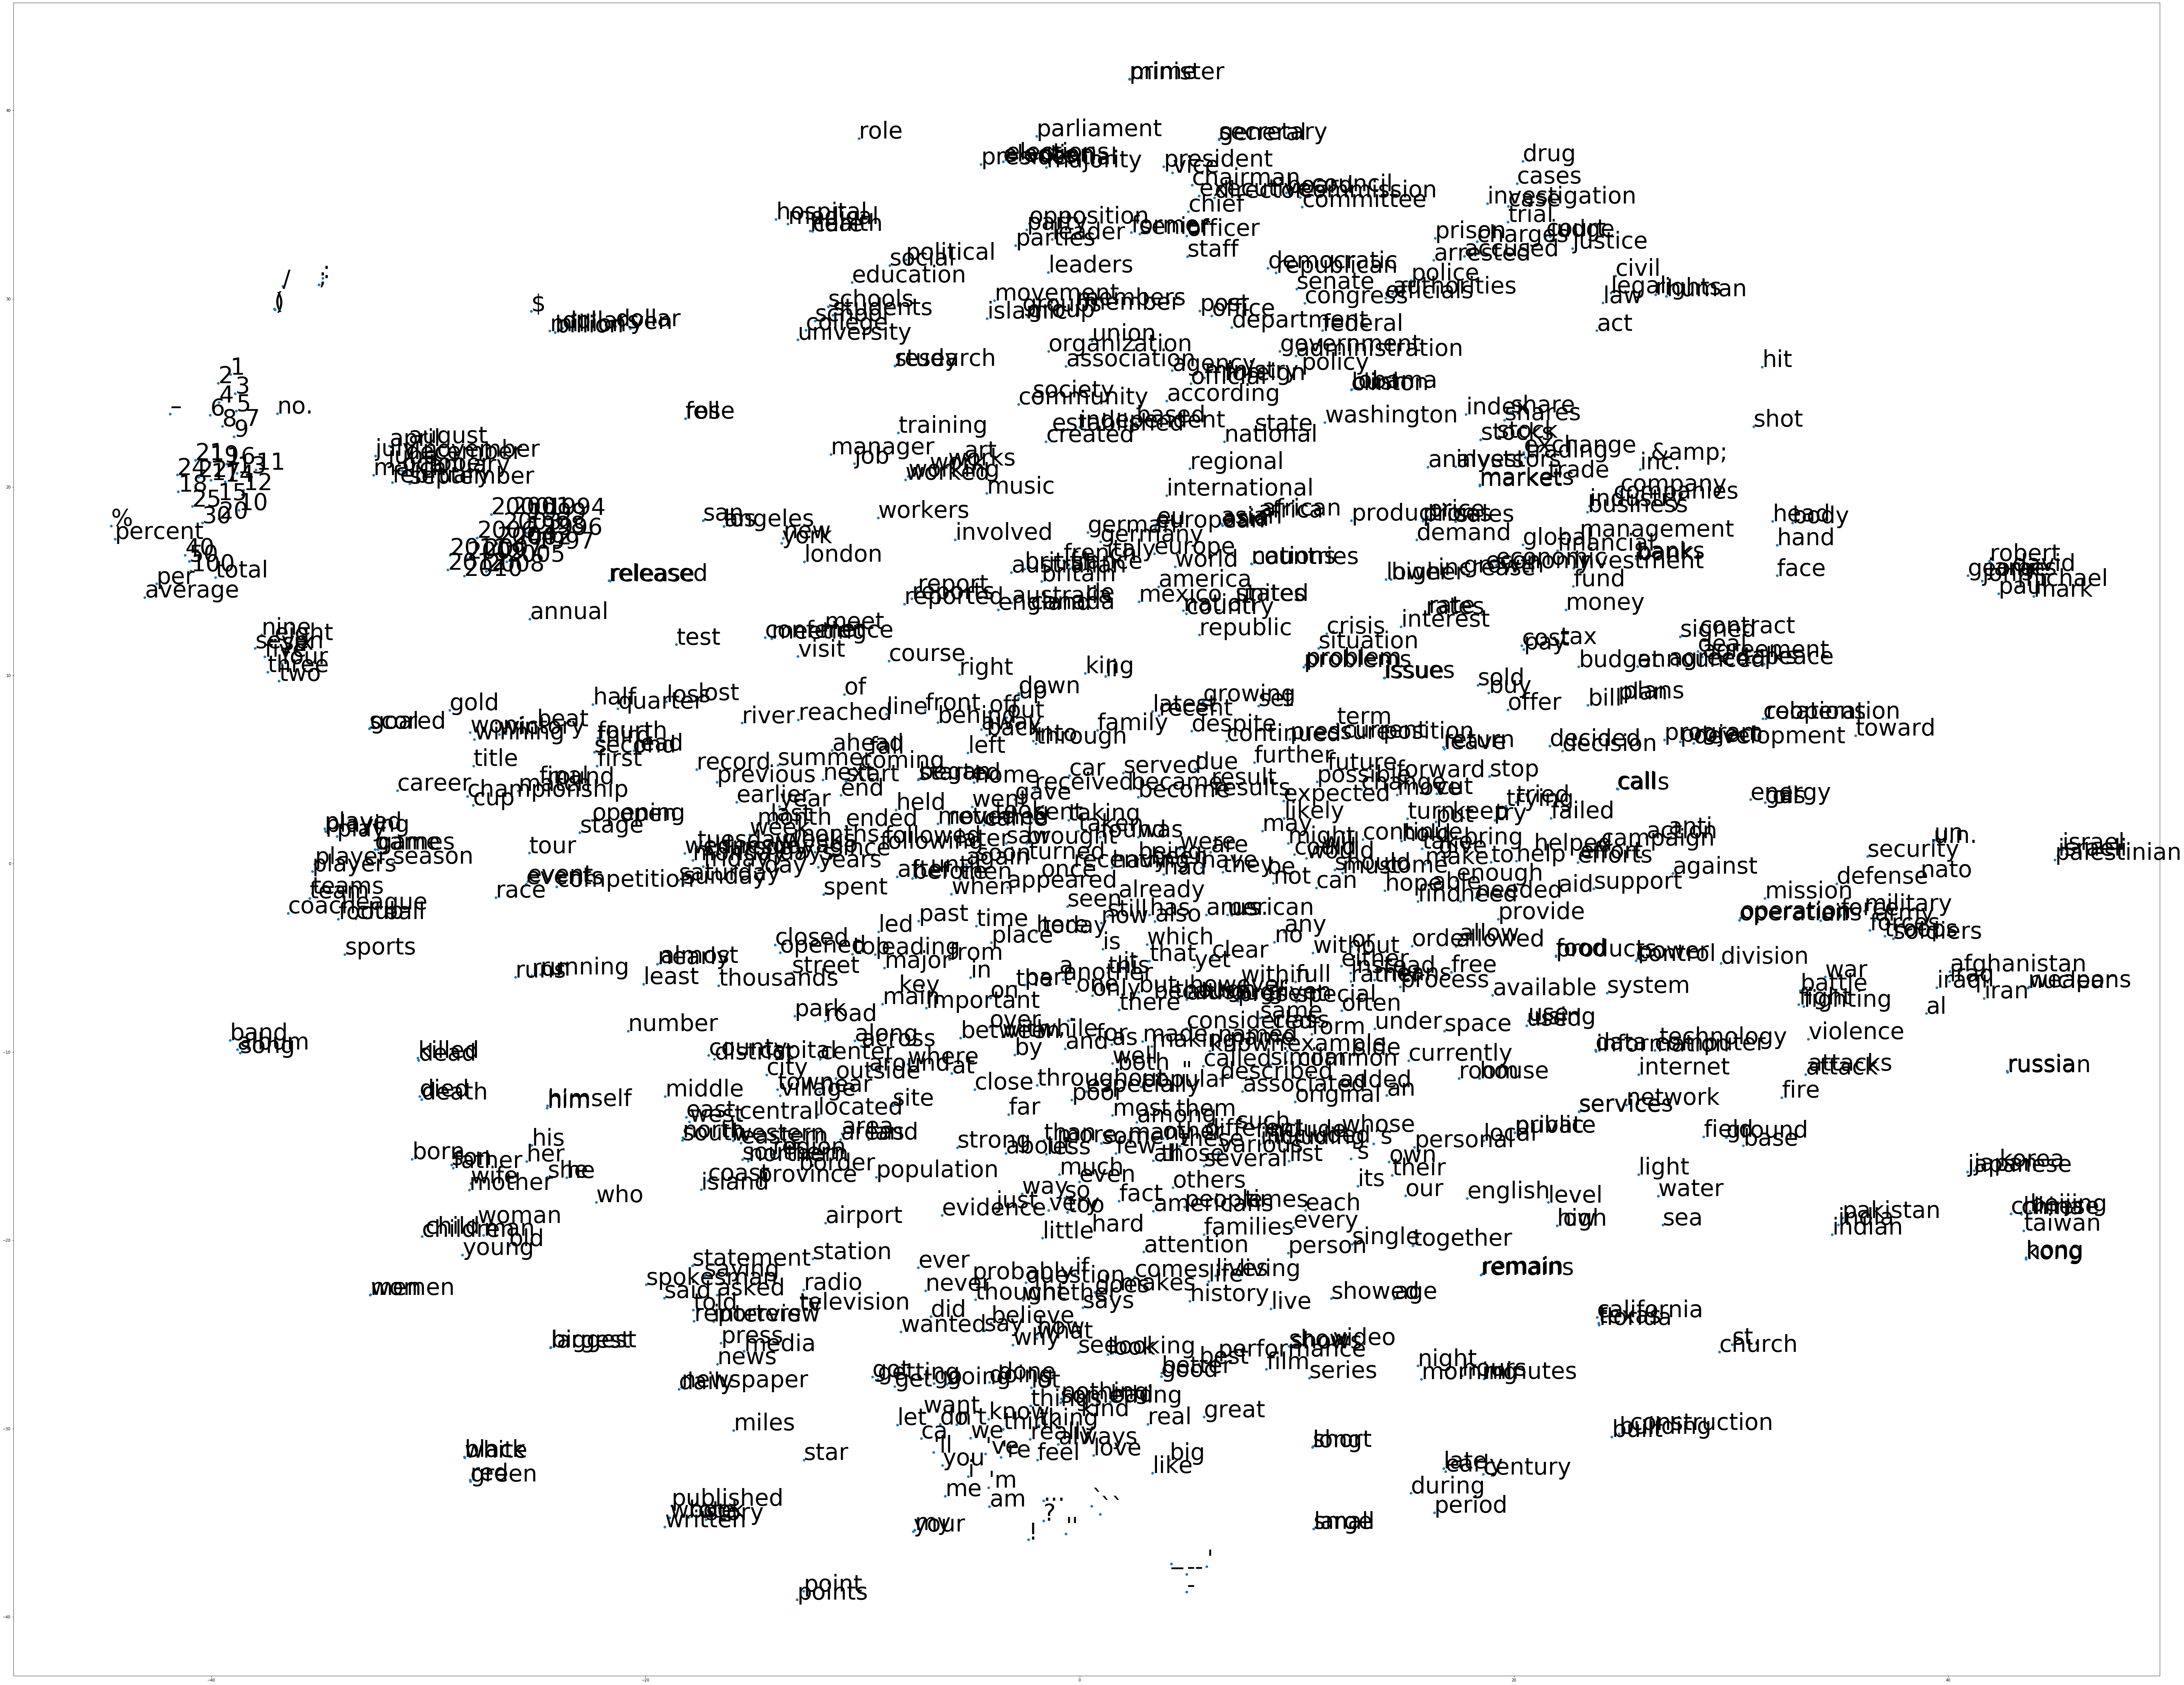

In [45]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_index.keys())
vectors = [embeddings_index[word] for word in words]
Y = tsne.fit_transform(vectors[:1000])
plt.figure(figsize=(100,80))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", fontsize=60)
plt.show()

# Jokes training - initial test; do not run

In [137]:
## create model
early_stopping_monitor = EarlyStopping(patience=50)
model_jokes_cnn = Sequential()
model_jokes_cnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_jokes], trainable=False))
model_jokes_cnn.add(Dropout(0.2))
model_jokes_cnn.add(Conv1D(64, 5, activation='relu'))
model_jokes_cnn.add(MaxPooling1D(pool_size=4))
model_jokes_cnn.add(LSTM(100))
model_jokes_cnn.add(Dense(1, activation='sigmoid'))
model_jokes_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history_jokes_cnn = model_jokes_cnn.fit(data_jokes, np.array(labels_jokes), 
                                validation_split=0.2, 
                                epochs=100, 
                                batch_size=20, 
                                callbacks=[early_stopping_monitor])
model_jokes_cnn.save('./models/jokes_model_cnn.h5')

# history = model.fit(train_x, train_y,
#               batch_size = batch_size,
#               epochs = epochs,
#               validation_data=(val_x, val_y))

Train on 158660 samples, validate on 39666 samples
Epoch 1/100
158660/158660 [==============================] - 194s 1ms/step - loss: 0.0637 - accuracy: 0.9856 - val_loss: 0.0645 - val_accuracy: 0.9855
Epoch 2/100
158660/158660 [==============================] - 155s 978us/step - loss: 0.0591 - accuracy: 0.9857 - val_loss: 0.0613 - val_accuracy: 0.9855
Epoch 3/100
158660/158660 [==============================] - 141s 891us/step - loss: 0.0562 - accuracy: 0.9857 - val_loss: 0.0618 - val_accuracy: 0.9849
Epoch 4/100
158660/158660 [==============================] - 141s 890us/step - loss: 0.0530 - accuracy: 0.9858 - val_loss: 0.0610 - val_accuracy: 0.9854
Epoch 5/100
158660/158660 [==============================] - 140s 881us/step - loss: 0.0503 - accuracy: 0.9860 - val_loss: 0.0626 - val_accuracy: 0.9849
Epoch 6/100
158660/158660 [==============================] - 165s 1ms/step - loss: 0.0473 - accuracy: 0.9861 - val_loss: 0.0652 - val_accuracy: 0.9852
Epoch 7/100
158660/158660 [========

Epoch 54/100
158660/158660 [==============================] - 124s 779us/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.0999 - val_accuracy: 0.9806


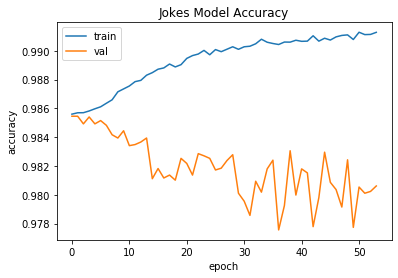

In [141]:
plt.plot(history_jokes_cnn.history['accuracy'])
plt.plot(history_jokes_cnn.history['val_accuracy'])
plt.title('Jokes Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

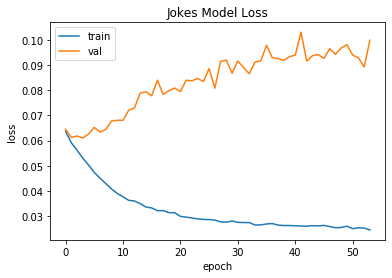

In [142]:
plt.plot(history_jokes_cnn.history['loss'])
plt.plot(history_jokes_cnn.history['val_loss'])
plt.title('Jokes Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Hate speech training - initial test; do not run

In [138]:
## create model
early_stopping_monitor = EarlyStopping(patience=50)
model_hate_cnn = Sequential()
model_hate_cnn.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix_hate], trainable=False))
model_hate_cnn.add(Dropout(0.2))
model_hate_cnn.add(Conv1D(64, 5, activation='relu'))
model_hate_cnn.add(MaxPooling1D(pool_size=4))
model_hate_cnn.add(LSTM(100))
model_hate_cnn.add(Dense(1, activation='sigmoid'))
model_hate_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history_hate_cnn = model_hate_cnn.fit(data_hate, np.array(labels_hate), 
                                validation_split=0.2, 
                                epochs=100, 
                                batch_size=5, 
                                callbacks=[early_stopping_monitor])
model_hate_cnn.save('./models/hate_model_cnn.h5')

Train on 19826 samples, validate on 4957 samples
Epoch 1/100
19826/19826 [==============================] - 46s 2ms/step - loss: 0.3020 - accuracy: 0.8691 - val_loss: 0.2570 - val_accuracy: 0.8852
Epoch 2/100
19826/19826 [==============================] - 43s 2ms/step - loss: 0.2590 - accuracy: 0.8893 - val_loss: 0.2501 - val_accuracy: 0.8961
Epoch 3/100
19826/19826 [==============================] - 44s 2ms/step - loss: 0.2384 - accuracy: 0.9011 - val_loss: 0.2516 - val_accuracy: 0.8967
Epoch 4/100
19826/19826 [==============================] - 45s 2ms/step - loss: 0.2184 - accuracy: 0.9105 - val_loss: 0.2552 - val_accuracy: 0.8965
Epoch 5/100
19826/19826 [==============================] - 43s 2ms/step - loss: 0.2027 - accuracy: 0.9190 - val_loss: 0.2565 - val_accuracy: 0.8967
Epoch 6/100
19826/19826 [==============================] - 45s 2ms/step - loss: 0.1881 - accuracy: 0.9243 - val_loss: 0.2657 - val_accuracy: 0.8963
Epoch 7/100
19826/19826 [==============================] - 43s 

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


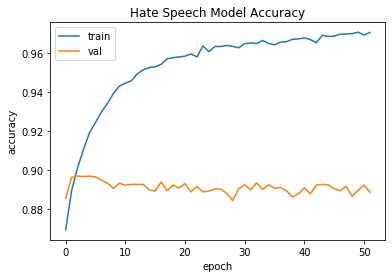

In [139]:
plt.plot(history_hate_cnn.history['accuracy'])
plt.plot(history_hate_cnn.history['val_accuracy'])
plt.title('Hate Speech Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

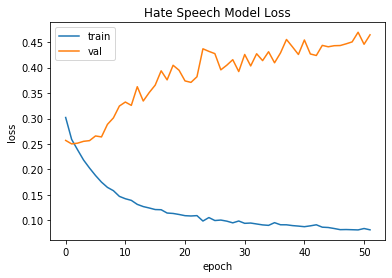

In [140]:
plt.plot(history_hate_cnn.history['loss'])
plt.plot(history_hate_cnn.history['val_loss'])
plt.title('Hate Speech Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Final (Everything, Balanced) Training

In [46]:
y_binary = np_utils.to_categorical(labels_final)

In [48]:
early_stopping_monitor = EarlyStopping(patience=3)
model_final = Sequential()
model_final.add(Embedding(vocabulary_size, 100, input_length=200, weights=[embedding_matrix_final], trainable=False))

# model_everything.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
# model_final.add(LSTM(100)) 
# model_final.add(Dense(1, activation='sigmoid'))
#                           #kernel_regularizer=regularizers.l2(0.01),
#                           #activity_regularizer=regularizers.l1(0.01)) 
# model_final.add(Dropout(0.2))
# model_final.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model_final.add(SpatialDropout1D(0.2))
model_final.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_final.add(Dense(3, activation='softmax'))
model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit train data
model_final_hist = model_final.fit(data_final, np.array(y_binary), 
                                validation_split=0.2, 
                                epochs=100, 
                                batch_size=32, 
                                callbacks=[early_stopping_monitor])
model_final.save('./models/model_final.h5')


Train on 9991 samples, validate on 2498 samples
Epoch 1/100
9991/9991 [==============================] - 103s 10ms/step - loss: 0.6881 - accuracy: 0.6970 - val_loss: 0.5196 - val_accuracy: 0.7814
Epoch 2/100
9991/9991 [==============================] - 96s 10ms/step - loss: 0.5432 - accuracy: 0.7758 - val_loss: 0.4623 - val_accuracy: 0.8159
Epoch 3/100
9991/9991 [==============================] - 67s 7ms/step - loss: 0.4802 - accuracy: 0.8056 - val_loss: 0.4248 - val_accuracy: 0.8271
Epoch 4/100
9991/9991 [==============================] - 64s 6ms/step - loss: 0.4384 - accuracy: 0.8231 - val_loss: 0.3947 - val_accuracy: 0.8459
Epoch 5/100
9991/9991 [==============================] - 60s 6ms/step - loss: 0.4880 - accuracy: 0.8066 - val_loss: 0.4700 - val_accuracy: 0.8022
Epoch 6/100
9991/9991 [==============================] - 56s 6ms/step - loss: 0.4555 - accuracy: 0.8216 - val_loss: 0.3870 - val_accuracy: 0.8483
Epoch 7/100
9991/9991 [==============================] - 57s 6ms/step - l

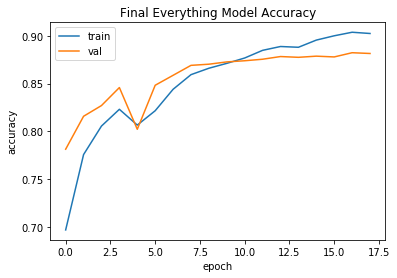

In [49]:
plt.plot(model_final_hist.history['accuracy'])
plt.plot(model_final_hist.history['val_accuracy'])
plt.title('Final Everything Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

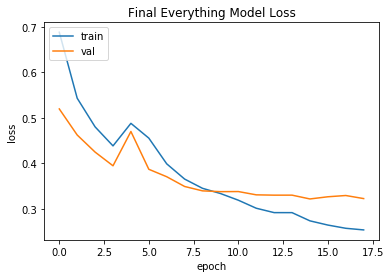

In [85]:
plt.plot(model_final_hist.history['loss'])
plt.plot(model_final_hist.history['val_loss'])
plt.title('Final Everything Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Final (Binary) Training

In [83]:
y_binary_bin = np_utils.to_categorical(labels_binary)
early_stopping_monitor = EarlyStopping(patience=3)
model_final_bin = Sequential()
model_final_bin.add(Embedding(vocabulary_size, 100, input_length=200, weights=[embedding_matrix_binary], trainable=False))


model_final_bin.add(SpatialDropout1D(0.2))
model_final_bin.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_final_bin.add(Dense(2, activation='sigmoid'))
model_final_bin.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit train data
model_final_bin_hist = model_final_bin.fit(data_binary, np.array(y_binary_bin), 
                                validation_split=0.2, 
                                epochs=100, 
                                batch_size=32, 
                                callbacks=[early_stopping_monitor])
model_final_bin.save('./models/model_bin.h5')

Train on 32992 samples, validate on 8248 samples
Epoch 1/100
32992/32992 [==============================] - 242s 7ms/step - loss: 0.2599 - accuracy: 0.8902 - val_loss: 0.1808 - val_accuracy: 0.9262
Epoch 2/100
32992/32992 [==============================] - 246s 7ms/step - loss: 0.1841 - accuracy: 0.9251 - val_loss: 0.1584 - val_accuracy: 0.9333
Epoch 3/100
32992/32992 [==============================] - 219s 7ms/step - loss: 0.1582 - accuracy: 0.9356 - val_loss: 0.1395 - val_accuracy: 0.9442
Epoch 4/100
32992/32992 [==============================] - 296s 9ms/step - loss: 0.1422 - accuracy: 0.9430 - val_loss: 0.1347 - val_accuracy: 0.9440
Epoch 5/100
32992/32992 [==============================] - 266s 8ms/step - loss: 0.1325 - accuracy: 0.9476 - val_loss: 0.1425 - val_accuracy: 0.9442
Epoch 6/100
32992/32992 [==============================] - 241s 7ms/step - loss: 0.1254 - accuracy: 0.9517 - val_loss: 0.1271 - val_accuracy: 0.9516
Epoch 7/100
32992/32992 [==============================] 

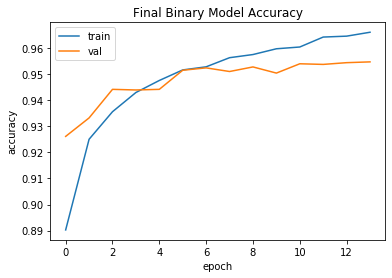

In [86]:
plt.plot(model_final_bin_hist.history['accuracy'])
plt.plot(model_final_bin_hist.history['val_accuracy'])
plt.title('Final Binary Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

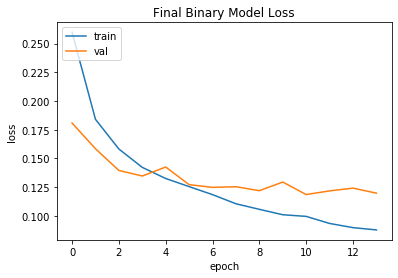

In [87]:
plt.plot(model_final_bin_hist.history['loss'])
plt.plot(model_final_bin_hist.history['val_loss'])
plt.title('Final Binary Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

## 3 categories

In [54]:
chandler_df['Text'] = chandler_df['Text'].map(lambda x: clean_text(x))
tokenizer_chandler = Tokenizer(num_words= vocabulary_size)
tokenizer_chandler.fit_on_texts(chandler_df['Text'])
sequences_chandler = tokenizer_chandler.texts_to_sequences(chandler_df['Text'])
chandler_test = pad_sequences(sequences_chandler, maxlen=200)

In [56]:
michael_df['line_text'] = michael_df['line_text'].map(lambda x: clean_text(x))
tokenizer_mike = Tokenizer(num_words= vocabulary_size)
tokenizer_mike.fit_on_texts(michael_df['line_text'])
sequences_mike = tokenizer_mike.texts_to_sequences(michael_df['line_text'])
mike_test = pad_sequences(sequences_mike, maxlen=200)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
predictions_mike_final = model_final.predict_classes(mike_test)
predictions_chandler_final = model_final.predict_classes(chandler_test)

In [129]:
def calc_results_3cat(character, predictions):
    funny = 0
    hate = 0
    neutral = 0
    for p in predictions:
        if p == 0:
            neutral += 1
        elif p == 1:
            funny += 1
        else:
            hate += 1
    f = funny/(funny+hate+neutral) * 100.0
    h = hate/(funny+hate+neutral) * 100.0
    n = neutral/(funny+hate+neutral) * 100.0
    print(str(character) + ": %.2f%% funny, %.2f%% offensive, and %.2f%% neutral" %(f, h, n))
    return (f, h, n)

In [130]:
def calc_results_2cat(character, predictions):
    funny = 0
    hate = 0
    for p in predictions:
        if p == 0:
            funny += 1
        elif p == 1:
            hate += 1
    f = funny/(funny+hate) * 100.0
    h = hate/(funny+hate) * 100.0
    print(str(character) + ": %.2f%% funny, %.2f%% offensive" %(f, h))
    return (f, h)

In [131]:
funny_mike, hate_mike, neutral_mike = calc_results_3cat("Michael", predictions_mike_final)
funny_chan, hate_chan, neutral_chan = calc_results_3cat("Chandler", predictions_chandler_final)

Michael: 37.81% funny, 24.88% offensive, and 37.31% neutral
Chandler: 33.35% funny, 25.26% offensive, and 41.39% neutral


In [137]:
res_mc_3cat = pd.DataFrame(np.array(['Chandler', "Michael"]))
res_mc_3cat.columns = ['character']
res_mc_3cat['funny'] = np.array([funny_chan, funny_mike])
res_mc_3cat['hate'] = np.array([hate_chan, hate_mike])
res_mc_3cat['neutral'] = np.array([neutral_chan, neutral_mike])

In [138]:
res_mc_3cat

character      funny       hate    neutral
0  Chandler  33.345095  25.264644  41.390261
1   Michael  37.810002  24.882590  37.307407

In [147]:
import plotly.graph_objects as go
chars = res_mc_3cat['character']
fig = go.Figure(data=[
    go.Bar(name='Funny', x=chars, y=res_mc_3cat['funny'], marker=dict(color='green')),
    go.Bar(name='Offensive', x=chars, y=res_mc_3cat['hate'], marker=dict(color='red')),
    go.Bar(name='Neutral', x=chars, y=res_mc_3cat['neutral'], marker=dict(color='gray'))
])
# Change the bar mode
fig.update_layout(title='Chandler vs Michael - 3 Category Percentage Results', barmode='group')
fig.update_xaxes(title_text='Character')
fig.update_yaxes(title_text='Percentage')
fig.show()

## 2 categories 

In [90]:
predictions_mike_bin = model_final_bin.predict_classes(mike_test)
predictions_chandler_bin = model_final_bin.predict_classes(chandler_test)

In [155]:
funny_mike_b, hate_mike_b = calc_results_2cat("Michael", predictions_mike_bin)
funny_chan_b, hate_chan_b = calc_results_2cat("Chandler", predictions_chandler_bin)

Michael: 54.19% funny, 45.81% offensive
Chandler: 52.60% funny, 47.40% offensive


In [156]:
res_mc_2cat = pd.DataFrame(np.array(['Chandler', "Michael"]))
res_mc_2cat.columns = ['character']
res_mc_2cat['funny'] = np.array([funny_chan_b, funny_mike_b])
res_mc_2cat['hate'] = np.array([hate_chan_b, hate_mike_b])

In [157]:
import plotly.graph_objects as go
chars = res_mc_2cat['character']
fig = go.Figure(data=[
    go.Bar(name='Funny', x=chars, y=res_mc_2cat['funny'], marker=dict(color='green')),
    go.Bar(name='Offensive', x=chars, y=res_mc_2cat['hate'], marker=dict(color='red'))
])
# Change the bar mode
fig.update_layout(title='Chandler vs Michael - 2 Category Percentage Results', barmode='group')
fig.update_xaxes(title_text='Character')
fig.update_yaxes(title_text='Percentage')
fig.show()

# PLOT TWIST - let's check Phoebe and Pam!

In [88]:
phoebe_df = friends_df.loc[friends_df["Speaker"] == "Phoebe"]
phoebe_df = phoebe_df.dropna()
phoebe_lines = np.array(friends_df.loc[friends_df["Speaker"] == "Phoebe"]["Text"])
phoebe_df['Text'] = phoebe_df['Text'].map(lambda x: clean_text(x))
tokenizer_phoebe = Tokenizer(num_words= vocabulary_size)
tokenizer_phoebe.fit_on_texts(phoebe_df['Text'])
sequences_phoebe = tokenizer_phoebe.texts_to_sequences(phoebe_df['Text'])
phoebe_test = pad_sequences(sequences_phoebe, maxlen=200)

In [89]:
pam_df = office_df.loc[office_df["speaker"] == "Pam"]
pam_df = pam_df.dropna()
pam_df['line_text'] = pam_df['line_text'].map(lambda x: clean_text(x))
tokenizer_pam = Tokenizer(num_words= vocabulary_size)
tokenizer_pam.fit_on_texts(pam_df['line_text'])
sequences_pam = tokenizer_pam.texts_to_sequences(pam_df['line_text'])
pam_test = pad_sequences(sequences_pam, maxlen=200)

## 3 categories

In [93]:
predictions_phoebe_final = model_final.predict_classes(phoebe_test)
predictions_pam_final = model_final.predict_classes(pam_test)

In [135]:
funny_phoebe, hate_phoebe, neutral_phoebe = calc_results_3cat("Phoebe", predictions_phoebe_final)
funny_pam, hate_pam, neutral_pam = calc_results_3cat("Pam", predictions_pam_final)

Phoebe: 36.45% funny, 31.79% offensive, and 31.76% neutral
Pam: 37.15% funny, 26.49% offensive, and 36.35% neutral


In [151]:
res_pp_3cat = pd.DataFrame(np.array(['Phoebe', "Pam"]))
res_pp_3cat.columns = ['character']
res_pp_3cat['funny'] = np.array([funny_phoebe, funny_pam])
res_pp_3cat['hate'] = np.array([hate_phoebe, hate_pam])
res_pp_3cat['neutral'] = np.array([neutral_phoebe, neutral_pam])

In [152]:
import plotly.graph_objects as go
chars = res_pp_3cat['character']
fig = go.Figure(data=[
    go.Bar(name='Funny', x=chars, y=res_pp_3cat['funny'], marker=dict(color='green')),
    go.Bar(name='Offensive', x=chars, y=res_pp_3cat['hate'], marker=dict(color='red')),
    go.Bar(name='Neutral', x=chars, y=res_pp_3cat['neutral'], marker=dict(color='gray'))
])
# Change the bar mode
fig.update_layout(title='Phoebe vs Pam - 3 Category Percentage Results', barmode='group')
fig.update_xaxes(title_text='Character')
fig.update_yaxes(title_text='Percentage')
fig.show()

## 2 categories

In [94]:
predictions_phoebe_bin = model_final_bin.predict_classes(phoebe_test)
predictions_pam_bin = model_final_bin.predict_classes(pam_test)

In [158]:
funny_phoebe_b, hate_phoebe_b = calc_results_2cat("Phoebe", predictions_phoebe_bin)
funny_pam_b, hate_pam_b = calc_results_2cat("Pam", predictions_pam_bin)

Phoebe: 52.99% funny, 47.01% offensive
Pam: 54.70% funny, 45.30% offensive


In [160]:
res_pp_2cat = pd.DataFrame(np.array(['Phoebe', "Pam"]))
res_pp_2cat.columns = ['character']
res_pp_2cat['funny'] = np.array([funny_phoebe_b, funny_pam_b])
res_pp_2cat['hate'] = np.array([hate_phoebe_b, hate_pam_b])

In [161]:
chars = res_pp_2cat['character']
fig = go.Figure(data=[
    go.Bar(name='Funny', x=chars, y=res_pp_2cat['funny'], marker=dict(color='green')),
    go.Bar(name='Offensive', x=chars, y=res_pp_2cat['hate'], marker=dict(color='red'))
])
# Change the bar mode
fig.update_layout(title='Phoebe vs Pam - 2 Category Percentage Results', barmode='group')
fig.update_xaxes(title_text='Character')
fig.update_yaxes(title_text='Percentage')
fig.show()

# THE END!

# ==============================================================

# Old tests below. Do not run

# Testing Chandler

In [51]:
chandler_df['Text'] = chandler_df['Text'].map(lambda x: clean_text(x))

In [53]:
tokenizer_chandler = Tokenizer(num_words= vocabulary_size)
tokenizer_chandler.fit_on_texts(chandler_df['Text'])

sequences_chandler = tokenizer_chandler.texts_to_sequences(chandler_df['Text'])
chandler_test = pad_sequences(sequences_chandler, maxlen=200)

In [85]:
predictions_chandler_jokes = model_jokes_cnn.predict_classes(chandler_test)

In [66]:
predictions_chandler_hate = model_hate_cnn.predict_classes(chandler_test)

In [93]:
joke = 0
notjoke = 0
for p in predictions_chandler_jokes:
    if p == 0:
        notjoke += 1
    else:
        joke += 1
j = joke/(joke+notjoke) * 100.0
nj = notjoke/(joke+notjoke) * 100.0
print("Chandler: %.2f%% funny rating; %.2f%% not funny rating" %(j, nj))

Chandler: 0.01% funny rating; 99.99% not funny rating


In [94]:
nonhate = 0
hate = 0
for p in predictions_chandler_hate:
    if p == 0:
        nonhate += 1
    else:
        hate += 1
h = hate/(hate+nonhate) * 100.0
n = nonhate/(hate+nonhate) * 100.0
print("Chandler: %.2f%% hate rating; %.2f%% nonhate rating" %(h, n))

Chandler: 96.02% hate rating; 3.98% nonhate rating


# Testing Michael

In [68]:
michael_df['line_text'] = michael_df['line_text'].map(lambda x: clean_text(x))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
tokenizer_mike = Tokenizer(num_words= vocabulary_size)
tokenizer_mike.fit_on_texts(michael_df['line_text'])

sequences_mike = tokenizer_mike.texts_to_sequences(michael_df['line_text'])
mike_test = pad_sequences(sequences_mike, maxlen=200)

In [116]:
predictions_mike_jokes = model_jokes_cnn.predict_classes(mike_test)

In [117]:
predictions_mike_hate = model_hate_cnn.predict_classes(mike_test)

In [96]:
joke = 0
notjoke = 0
for p in predictions_mike_jokes:
    if p == 0:
        notjoke += 1
    else:
        joke += 1
j = joke/(joke+notjoke) * 100.0
nj = notjoke/(joke+notjoke) * 100.0
print("Michael: %.2f%% funny rating; %.2f%% not funny rating" %(j, nj))

Michael: 0.02% funny rating; 99.98% not funny rating


In [95]:
nonhate = 0
hate = 0
for p in predictions_mike_hate:
    if p == 0:
        nonhate += 1
    else:
        hate += 1
h = hate/(hate+nonhate) * 100.0
n = nonhate/(hate+nonhate) * 100.0
print("Michael: %.2f%% hate rating; %.2f%% nonhate rating" %(h, n))

Michael: 94.78% hate rating; 5.22% nonhate rating


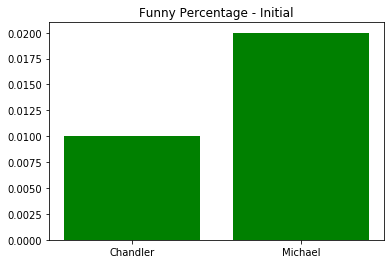

In [64]:
height = [0.01, 0.02]
bars = ('Chandler', "Michael")
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color="green")
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Funny Percentage - Initial')
 
# Show graphic
plt.show()

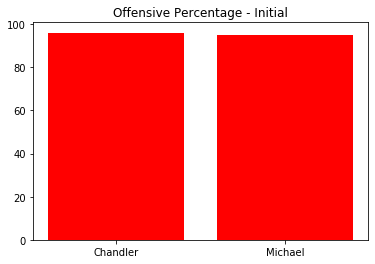

In [66]:
height = [96.02, 94.78]
bars = ('Chandler', "Michael")
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color="red")
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Offensive Percentage - Initial')
 
# Show graphic
plt.show()

## Testing the Everything Model

In [70]:
predictions_mike_final = model_final.predict_classes(mike_test)
predictions_chandler_final = model_final.predict_classes(chandler_test)

In [71]:
funny = 0
hate = 0
neutral = 0
for p in predictions_mike_final:
    if p == 0:
        neutral += 1
    elif p == 1:
        funny += 1
    else:
        hate += 1
f = funny/(funny+hate+neutral) * 100.0
h = hate/(funny+hate+neutral) * 100.0
n = neutral/(funny+hate+neutral) * 100.0
print("Michael: %.2f%% funny, %.2f%% offensive, and %.2f%% neutral" %(f, h, n))

Michael: 49.20% funny, 21.86% offensive, and 28.94% neutral


In [72]:
funny = 0
hate = 0
neutral = 0
for p in predictions_chandler_final:
    if p == 0:
        neutral += 1
    elif p == 1:
        funny += 1
    else:
        hate += 1
f = funny/(funny+hate+neutral) * 100.0
h = hate/(funny+hate+neutral) * 100.0
n = neutral/(funny+hate+neutral) * 100.0
print("Chandler: %.2f%% funny, %.2f%% offensive, and %.2f%% neutral" %(f, h, n))

Chandler: 51.07% funny, 20.80% offensive, and 28.13% neutral


In [166]:
predictions_mike_everything = model_everything_3cat.predict_classes(mike_test)
predictions_chandler_everything = model_everything_3cat.predict_classes(chandler_test)

In [167]:
funny = 0
hate = 0
neutral = 0
for p in predictions_mike_everything:
    if p == 0:
        neutral += 1
    elif p == 1:
        funny += 1
    else:
        hate += 1
f = funny/(funny+hate+neutral) * 100.0
h = hate/(funny+hate+neutral) * 100.0
n = neutral/(funny+hate+neutral) * 100.0
print("Michael: %.2f%% funny, %.2f%% offensive, and %.2f%% neutral" %(f, h, n))

Michael: 18.74% funny, 0.00% offensive, and 81.26% neutral


In [168]:
funny = 0
hate = 0
neutral = 0
for p in predictions_chandler_everything:
    if p == 0:
        neutral += 1
    elif p == 1:
        funny += 1
    else:
        hate += 1
f = funny/(funny+hate+neutral) * 100.0
h = hate/(funny+hate+neutral) * 100.0
n = neutral/(funny+hate+neutral) * 100.0
print("Chandler: %.2f%% funny, %.2f%% offensive, and %.2f%% neutral" %(f, h, n))

Chandler: 18.79% funny, 0.00% offensive, and 81.21% neutral


In [99]:
funny = 0
hate = 0
for p in predictions_mike_everything:
    if p == 0:
        hate += 1
    else:
        funny += 1
f = funny/(funny+hate) * 100.0
h = hate/(funny+hate) * 100.0
print("Michael: %.2f%% funny and %.2f%% offensive" %(f, h))

Michael: 55.95% funny and 44.05% offensive


In [102]:
funny = 0
hate = 0
for p in predictions_chandler_everything:
    if p == 0:
        hate += 1
    else:
        funny += 1
f = funny/(funny+hate) * 100.0
h = hate/(funny+hate) * 100.0
print("Chandler: %.2f%% funny and %.2f%% offensive" %(f, h))

Chandler: 54.02% funny and 45.98% offensive


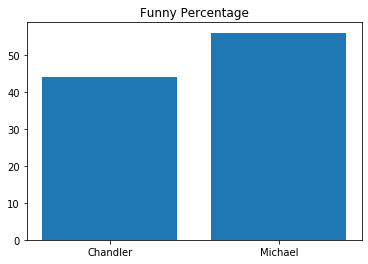

In [103]:
height = [44.05,55.95]
bars = ('Chandler', "Michael")
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Funny Percentage')
 
# Show graphic
plt.show()

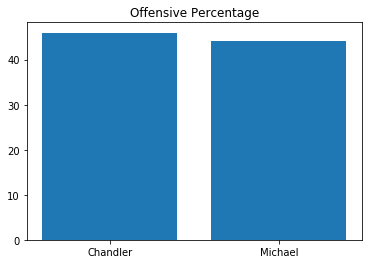

In [104]:
height = [45.98, 44.05]
bars = ('Chandler', "Michael")
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Offensive Percentage')
 
# Show graphic
plt.show()